In [ ]:
import numpy as np
import pandas as pd
import string as st
import re
import nltk
from nltk import PorterStemmer, WordNetLemmatizer
import nltk.corpus
import os
nltk.download('all')

##Exercise 1: Perform Sentiment Analysis to compare the feature extraction methods like bag of words, TF-IDF, Word to Vector

In [6]:
df = pd.read_csv("/content/sample_data/IMDB Dataset.csv", engine='python',nrows=1000)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"")
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return lemma_words

def preprocess_join(li):
    return " ".join(li)

df['review_preprocessed']=df['review'].map(lambda s:preprocess(s))
df['review_preprocessed_sent']=df['review_preprocessed'].map(lambda s:preprocess_join(s))

In [8]:
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm, preprocessing
label_encoder = preprocessing.LabelEncoder()

df['sentiment']= label_encoder.fit_transform(df['sentiment'])
df.head()

,review,sentiment,review_preprocessed,review_preprocessed_sent
0,One of the other reviewers has mentioned that ...,1,"[one, review, mention, watch, episod, hook, ri...",one review mention watch episod hook right exa...
1,A wonderful little production. <br /><br />The...,1,"[wonder, littl, product, film, techniqu, unass...",wonder littl product film techniqu unassum old...
2,I thought this was a wonderful way to spend ti...,1,"[thought, wonder, way, spend, time, hot, summe...",thought wonder way spend time hot summer weeke...
3,Basically there's a family where a little boy ...,0,"[basic, famili, littl, boy, jake, think, zombi...",basic famili littl boy jake think zombi closet...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"[petter, mattei, love, time, money, visual, st...",petter mattei love time money visual stun film...


###Bag of Words

In [9]:
import heapq

word2count = {}
for data in df['review_preprocessed']:
    for word in data:
        if word not in word2count.keys():
            word2count[word] = 1
        else:
            word2count[word] += 1

freq_words = heapq.nlargest(100, word2count, key=word2count.get)
X = []
for data in df['review_preprocessed']:
    vector = []
    for word in freq_words:
        if word in data:
            vector.append(1)
        else:
            vector.append(0)
    X.append(vector)
X_bow = np.asarray(X)
df['bag_of_words'] = list(X_bow)
df.head()

,review,sentiment,review_preprocessed,review_preprocessed_sent,bag_of_words
0,One of the other reviewers has mentioned that ...,1,"[one, review, mention, watch, episod, hook, ri...",one review mention watch episod hook right exa...,"[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, ..."
1,A wonderful little production. <br /><br />The...,1,"[wonder, littl, product, film, techniqu, unass...",wonder littl product film techniqu unassum old...,"[0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, ..."
2,I thought this was a wonderful way to spend ti...,1,"[thought, wonder, way, spend, time, hot, summe...",thought wonder way spend time hot summer weeke...,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, ..."
3,Basically there's a family where a little boy ...,0,"[basic, famili, littl, boy, jake, think, zombi...",basic famili littl boy jake think zombi closet...,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"[petter, mattei, love, time, money, visual, st...",petter mattei love time money visual stun film...,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(list(X_bow), list(df['sentiment']), test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the classifier
acc_bow = accuracy_score(y_test, y_pred)
print("Accuracy of the model using Bag of Words is",acc_bow)

Accuracy of the model using Bag of Words is 0.725


### TF-IDF

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer()

X_counts = count_vector.fit_transform(df['review_preprocessed_sent'])

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

X_tfidf = tfidf_transformer.fit_transform(X_counts)
df['tf_idf'] = list(X_tfidf)
df.head()

,review,sentiment,review_preprocessed,review_preprocessed_sent,bag_of_words,tf_idf
0,One of the other reviewers has mentioned that ...,1,"[one, review, mention, watch, episod, hook, ri...",one review mention watch episod hook right exa...,"[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...","(0, 12078)\t0.03166985701601707\n (0, 12053..."
1,A wonderful little production. <br /><br />The...,1,"[wonder, littl, product, film, techniqu, unass...",wonder littl product film techniqu unassum old...,"[0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, ...","(0, 12097)\t0.08308914570482852\n (0, 12073..."
2,I thought this was a wonderful way to spend ti...,1,"[thought, wonder, way, spend, time, hot, summe...",thought wonder way spend time hot summer weeke...,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, ...","(0, 12161)\t0.0754956745415026\n (0, 12137)..."
3,Basically there's a family where a little boy ...,0,"[basic, famili, littl, boy, jake, think, zombi...",basic famili littl boy jake think zombi closet...,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","(0, 12214)\t0.20845487092925877\n (0, 11869..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"[petter, mattei, love, time, money, visual, st...",petter mattei love time money visual stun film...,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","(0, 12158)\t0.08593645297575551\n (0, 12061..."


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['sentiment'], test_size=0.2, random_state=42)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the classifier
acc_tfidf = accuracy_score(y_test, y_pred)
print("Accuracy of the model using TF-IDF is", acc_tfidf)

Accuracy of the model using TF-IDF is 0.82


###Word2Vec

In [13]:
import gensim
w2v = gensim.models.Word2Vec(df['review_preprocessed'], window=10, min_count=2)

In [15]:
def document_vector(doc):
    doc = [word for word in doc if word in w2v.wv.index_to_key]
    return np.mean(w2v.wv[doc], axis=0)
df['word2vec'] = df['review_preprocessed'].apply(document_vector)
df.head()

,review,sentiment,review_preprocessed,review_preprocessed_sent,bag_of_words,tf_idf,word2vec
0,One of the other reviewers has mentioned that ...,1,"[one, review, mention, watch, episod, hook, ri...",one review mention watch episod hook right exa...,"[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...","(0, 12078)\t0.03166985701601707\n (0, 12053...","[-0.3287517, 0.4413725, 0.30551633, 0.02399876..."
1,A wonderful little production. <br /><br />The...,1,"[wonder, littl, product, film, techniqu, unass...",wonder littl product film techniqu unassum old...,"[0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, ...","(0, 12097)\t0.08308914570482852\n (0, 12073...","[-0.37243655, 0.49614835, 0.34496045, 0.025089..."
2,I thought this was a wonderful way to spend ti...,1,"[thought, wonder, way, spend, time, hot, summe...",thought wonder way spend time hot summer weeke...,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, ...","(0, 12161)\t0.0754956745415026\n (0, 12137)...","[-0.34394503, 0.46007508, 0.31733337, 0.025551..."
3,Basically there's a family where a little boy ...,0,"[basic, famili, littl, boy, jake, think, zombi...",basic famili littl boy jake think zombi closet...,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","(0, 12214)\t0.20845487092925877\n (0, 11869...","[-0.36374825, 0.48923367, 0.33879316, 0.028756..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,"[petter, mattei, love, time, money, visual, st...",petter mattei love time money visual stun film...,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","(0, 12158)\t0.08593645297575551\n (0, 12061...","[-0.39056212, 0.52401906, 0.3629343, 0.0294029..."


In [16]:
X_train, X_test, y_train, y_test = train_test_split(list(df['word2vec']), df['sentiment'], test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the classifier
acc_w2v = accuracy_score(y_test, y_pred)
print("Accuracy of the model using Word2Vec is", acc_w2v)

Accuracy of the model using Word2Vec is 0.53


##Exercise 2: Analyze and compare the performance of each feature representation on the sentiment analysis task. Consider factors such as accuracy, computational efficiency, and interpretability.

###Accuracy

Text(0.5, 1.0, 'Comparision of accuracy for feature representation techniques')

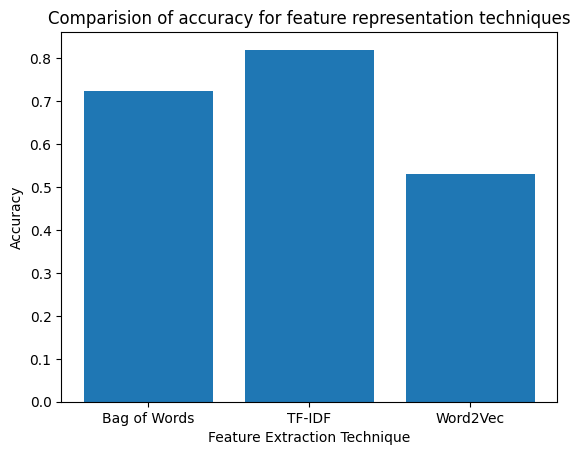

In [21]:
import matplotlib.pyplot as plt

data = {'Bag of Words':acc_bow, 'TF-IDF':acc_tfidf, 'Word2Vec':acc_w2v}
feat = list(data.keys())
values = list(data.values())
plt.bar(feat, values)

plt.xlabel("Feature Extraction Technique")
plt.ylabel("Accuracy")
plt.title("Comparision of accuracy for feature representation techniques")

###Computational Efficiency and Interpretability
Bag of Words is the most computationally efficient and interpretable, followed by bag of words and then Word2Vec, as the complexity increases in that order.